# **Comprehensive Model Evaluation and Export**

## 📋 Overview
This notebook performs comprehensive evaluation of all optimized machine learning models for temperature prediction. It includes detailed analysis, visualization, and export of results for production deployment.

## 🎯 Objectives
1. **Model Loading**: Load all optimized models and their metadata from artifacts
2. **Performance Evaluation**: Re-evaluate all models on the test set with consistent metrics
3. **Comparative Analysis**: Compare model performance using multiple metrics (MAE, RMSE, R²)
4. **Residual Analysis**: Analyze prediction errors to validate model assumptions
5. **Feature Importance**: Identify and compare important features across models
6. **Error Analysis**: 
   - **Spatial**: Analyze performance across different provinces
   - **Temporal**: Evaluate performance across months and seasons
7. **Visualization**: Create comprehensive visualizations for model interpretation
8. **Export**: Save all results, predictions, and metrics for documentation and deployment

## 📊 Key Outputs
- Predictions from all models with error metrics
- Model comparison tables and visualizations
- Feature importance rankings
- Error analysis by province, month, and season
- Heatmaps showing spatiotemporal error patterns
- Comprehensive evaluation summary (JSON)

## 🔧 Models Evaluated
- **XGBoost** (XGB): Gradient boosting with extreme performance optimization
- **LightGBM** (LGB): Fast gradient boosting with leaf-wise growth
- **HistGradientBoosting** (HGB): Sklearn's histogram-based gradient boosting
- **Random Forest** (RF): Ensemble of decision trees

---

## 📖 Usage Guide

### Prerequisites
Before running this notebook, ensure you have:
1. ✅ Completed model training and hyperparameter optimization (Notebook 4)
2. ✅ Generated model artifacts in `../artifacts/` directory:
   - Model files (`.joblib`)
   - Metadata files (`.json`)
   - Summary file (`all_models_summary_*.json`)
3. ✅ Test data available in `../data/splits/fe_dt_test.csv`
4. ✅ Feature schema in `../data/splits/fe_dt_selected_columns.json`

### How to Run
1. **Run all cells sequentially** - The notebook is designed to run from top to bottom
2. **Check outputs** - Verify that models load correctly and metrics match expectations
3. **Review visualizations** - Examine plots for insights into model performance
4. **Verify exports** - Confirm that results are saved to `../results/` and `../figures/`

### Expected Runtime
- **Total**: ~5-15 minutes (depending on dataset size and number of models)
- Model loading: ~30 seconds
- Evaluation: ~2-5 minutes
- Visualization: ~3-7 minutes
- Export: ~30 seconds

### Outputs
- **CSV Files**: Predictions, metrics, error analysis tables in `results/`
- **PNG Files**: All visualizations in `figures/`
- **JSON Files**: Comprehensive evaluation summary in `results/`

---

In [ ]:
# SETUP AND IMPORTS
# This cell imports all necessary libraries and configures the environment
# for model evaluation and visualization.

import os
import sys
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import json
import joblib
from pathlib import Path

# Add project root to Python path for module imports
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.append(project_root)

# Core ML libraries
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.linear_model import LinearRegression

# Boosting libraries
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# Model interpretation
import shap

# Custom utilities from project
from src.utils.performance_monitor import timed_mem_call
from src.utils.scores import _regression_scores
from src.utils.visualization import plot_predictions_vs_actual

# CONFIGURATION
# Set random seed for reproducibility
SEED = 42
np.random.seed(SEED)

# Configure warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# INITIALIZATION
print("COMPREHENSIVE MODEL EVALUATION AND EXPORT")
print(f"Random Seed: {SEED}")
print(f"Timestamp: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"Python Version: {sys.version.split()[0]}")

## 1. Load Models and Metadata from Artifacts

**Purpose**: Load all optimized models and their training metadata:
- Find the latest model summary file in the artifacts directory
- Load model objects (`.joblib` files) for prediction
- Load metadata (`.json` files) containing:
  - Model hyperparameters
  - Training/validation metrics (CV MAE, Test MAE)
  - Feature names and importance
  - Training configuration and timestamps

**Expected Artifacts**:
- `all_models_summary_*.json`: Summary of all trained models
- `*_optimized_*.joblib`: Serialized model objects
- `*_optimized_metadata_*.json`: Model metadata and metrics

In [ ]:
# LOAD MODEL ARTIFACTS
print("\nLOADING MODEL ARTIFACTS")

# Define artifacts directory
artifacts_dir = Path('../artifacts')

# Find the latest model summary file
summary_files = list(artifacts_dir.glob('all_models_summary_*.json'))
if not summary_files:
    raise FileNotFoundError("No model summary found in artifacts/")

latest_summary = max(summary_files, key=lambda x: x.stat().st_mtime)
print(f"\n✓ Loading model summary from: {latest_summary.name}")

# Load summary JSON
with open(latest_summary, 'r') as f:
    models_summary = json.load(f)

print(f"  - Models saved: {models_summary['models_saved']}")
print(f"  - Best model: {models_summary['best_model'].upper()}")
print(f"  - Timestamp: {models_summary['timestamp']}")

# Extract metadata
timestamp = models_summary['timestamp']
models_info = models_summary['models']

# LOAD INDIVIDUAL MODELS AND METADATA
loaded_models = {}
loaded_metadata = {}

print("\nLoading individual model files...")

for model_key, info in models_info.items():
    model_file = artifacts_dir / info['model_file']
    metadata_file = artifacts_dir / info['metadata_file']
    
    if model_file.exists() and metadata_file.exists():
        print(f"\n✓ {model_key.upper()}")
        
        # Load model object
        model = joblib.load(model_file)
        loaded_models[model_key] = model
        print(f"  - Model: {info['model_file']}")
        
        # Load metadata
        with open(metadata_file, 'r') as f:
            metadata = json.load(f)
        loaded_metadata[model_key] = metadata
        print(f"  - Metadata: {info['metadata_file']}")
        
        # Display performance metrics from training
        print(f"  - Test MAE: {info.get('test_mae', 'N/A'):.4f}°C")
        print(f"  - CV MAE: {info.get('cv_mae', 'N/A'):.4f}°C")
    else:
        print(f"\n⚠ WARNING: Files not found for {model_key}")

# Identify best model
best_model_key = models_summary['best_model']
print(f"\nBEST MODEL: {best_model_key.upper()}")

## 2. Load and Prepare Test Data

**Purpose**: Load the test dataset and prepare features for evaluation:
- Load test data from CSV with datetime parsing
- Separate features (X) and target variable (y)
- Verify feature alignment with model expectations
- Handle any missing or extra features

**Data Validation**:
- Check feature names match model training
- Verify data types and missing values
- Confirm date range coverage
- Ensure proper feature ordering for prediction

**Note**: Feature alignment is critical - models expect specific features in a specific order.

In [ ]:
# LOAD TEST DATA
# This function loads test data and handles feature alignment

def load_test_data(test_file, schema_json=None):
    """
    Load test data with proper feature ordering.
    
    Args:
        test_file: Path to test CSV file
        schema_json: Optional path to JSON file containing feature order
        
    Returns:
        X_test: Feature matrix
        y_test: Target variable
        df: Full dataframe with metadata
    """
    test_path = Path(test_file)
    df = pd.read_csv(test_path, parse_dates=['datetime'])
    
    # Separate target variable
    y_test = df['target']
    
    # Drop target and metadata columns
    drop_cols = [c for c in ['target', 'datetime', 'name'] if c in df.columns]
    X_test = df.drop(columns=drop_cols)
    
    # Reorder columns according to schema if provided
    if schema_json is not None:
        schema_path = Path(schema_json)
        if schema_path.exists():
            cols = pd.read_json(schema_path, typ='series')
            cols = list(cols.values) if isinstance(cols, pd.Series) else list(cols)
            # Only keep columns that exist in both
            cols = [c for c in cols if c in X_test.columns]
            X_test = X_test[cols]
    
    print(f"✓ Loaded test data: {df.shape}")
    print(f"  - Features: {X_test.shape[1]}")
    print(f"  - Samples: {X_test.shape[0]}")
    print(f"  - Date range: {df['datetime'].min().date()} to {df['datetime'].max().date()}")
    
    return X_test, y_test, df

# LOAD AND VALIDATE TEST DATA
print("\nLOADING TEST DATA")

X_test, y_test, df_test = load_test_data(
    '../data/splits/fe_dt_test.csv',
    schema_json='../data/splits/fe_dt_selected_columns.json'
)

# FEATURE ALIGNMENT VERIFICATION
print("\nFEATURE ALIGNMENT VERIFICATION")

for model_key, metadata in loaded_metadata.items():
    model_features = set(metadata.get('features', []))
    test_features = set(X_test.columns)
    
    missing = model_features - test_features
    extra = test_features - model_features
    
    if missing:
        print(f"⚠ {model_key.upper()}: Missing {len(missing)} features: {list(missing)[:5]}")
    if extra:
        print(f"⚠ {model_key.upper()}: Extra {len(extra)} features: {list(extra)[:5]}")
    if not missing and not extra:
        print(f"✓ {model_key.upper()}: Features aligned ({len(test_features)} features)")

# Get expected feature order from best model
best_features = loaded_metadata[best_model_key].get('features', [])
print(f"\n✓ Best model ({best_model_key.upper()}) expects {len(best_features)} features")

## 3. Comprehensive Model Evaluation

**Purpose**: Re-evaluate all models on the test set with comprehensive metrics:
- Make predictions using each model on aligned test features
- Calculate regression metrics:
  - **MAE (Mean Absolute Error)**: Average magnitude of errors in °C
  - **RMSE (Root Mean Squared Error)**: Penalizes larger errors more heavily
  - **R² (Coefficient of Determination)**: Proportion of variance explained (0-1)
- Compare with metadata metrics to verify consistency
- Rank models by performance

**Evaluation Strategy**:
1. Align features for each model
2. Generate predictions
3. Calculate metrics
4. Create comparison table
5. Identify best model

**Success Criteria**: Models should perform similarly to training/validation metrics.

In [4]:
# Re-evaluate all models on test set
print("RE-EVALUATING ALL MODELS ON TEST SET")


evaluation_results = {}
all_predictions = {}

for model_key, model in loaded_models.items():
    print(f"\nEvaluating {model_key.upper()}")
    
    # Get expected features for this model
    expected_features = loaded_metadata[model_key].get('features', X_test.columns.tolist())
    
    # Ensure X_test has the right features in the right order
    # Create a DataFrame with all expected features
    X_test_aligned = pd.DataFrame(index=X_test.index)
    
    for feat in expected_features:
        if feat in X_test.columns:
            # Feature exists in test data, use it
            X_test_aligned[feat] = X_test[feat]
        else:
            # Feature missing in test data, fill with 0
            print(f"Warning: Feature '{feat}' missing in test data, filling with 0")
            X_test_aligned[feat] = 0
    
    # Reorder to match expected features order exactly
    X_test_ordered = X_test_aligned[expected_features]
    
    # Make predictions
    y_pred = model.predict(X_test_ordered)
    
    # Calculate metrics
    mae, rmse, r2 = _regression_scores(y_test, y_pred)
    
    # Store results
    evaluation_results[model_key] = {
        'test_mae': mae,
        'test_rmse': rmse,
        'test_r2': r2,
        'cv_mae': loaded_metadata[model_key].get('cv_mae'),
        'test_mae_metadata': loaded_metadata[model_key].get('test_mae')
    }
    
    all_predictions[model_key] = y_pred
    
    print(f"Test MAE:  {mae:.4f}°C")
    print(f"Test RMSE: {rmse:.4f}°C")
    print(f"Test R²:   {r2:.4f}")
    
    # Compare with metadata
    if loaded_metadata[model_key].get('test_mae') is not None:
        metadata_mae = loaded_metadata[model_key]['test_mae']
        diff = abs(mae - metadata_mae)
        if diff < 0.0001:
            print(f"Matches metadata (MAE: {metadata_mae:.4f})")
        else:
            print(f"Difference from metadata: {diff:.6f}°C")

# Create comparison DataFrame
comparison_df = pd.DataFrame({
    model_key: {
        'Model': loaded_metadata[model_key].get('model_type', model_key),
        'Test MAE (°C)': results['test_mae'],
        'Test RMSE (°C)': results['test_rmse'],
        'Test R²': results['test_r2'],
        'CV MAE (°C)': results.get('cv_mae', 'N/A')
    }
    for model_key, results in evaluation_results.items()
}).T

comparison_df = comparison_df.sort_values('Test MAE (°C)')
print("MODEL COMPARISON (Sorted by Test MAE)")
display(comparison_df.round(4))


RE-EVALUATING ALL MODELS ON TEST SET

Evaluating XGB
Test MAE:  1.0076°C
Test RMSE: 1.3179°C
Test R²:   0.5855
Difference from metadata: 0.009045°C

Evaluating LGB
Test MAE:  1.0046°C
Test RMSE: 1.3132°C
Test R²:   0.5884
Difference from metadata: 0.010827°C

Evaluating HGB
Test MAE:  1.0048°C
Test RMSE: 1.3134°C
Test R²:   0.5883
Difference from metadata: 0.015229°C

Evaluating RF
Test MAE:  0.9857°C
Test RMSE: 1.2819°C
Test R²:   0.6078
Difference from metadata: 0.004215°C
MODEL COMPARISON (Sorted by Test MAE)


,Model,Test MAE (°C),Test RMSE (°C),Test R²,CV MAE (°C)
rf,RandomForest,0.985727,1.281934,0.607755,0.94567
lgb,LightGBM,1.004586,1.313165,0.58841,0.88726
hgb,HistGradientBoosting,1.004818,1.313413,0.588255,0.937879
xgb,XGBoost,1.007628,1.317856,0.585465,0.885093


### 3.1. Predictions vs Actual Visualization

**Visualization Components**:
- Scatter plots comparing predicted vs actual temperatures for each model
- Perfect prediction line (y = x) as reference
- Error metrics (MAE, R²) displayed on each plot
- Individual subplots for each model to facilitate comparison

**Interpretation Guide**:
- Points close to the red line indicate accurate predictions
- Scatter above the line = overprediction
- Scatter below the line = underprediction
- Tighter clustering around the line = better model performance

Saved: figures/predictions_vs_actual_all_models.png


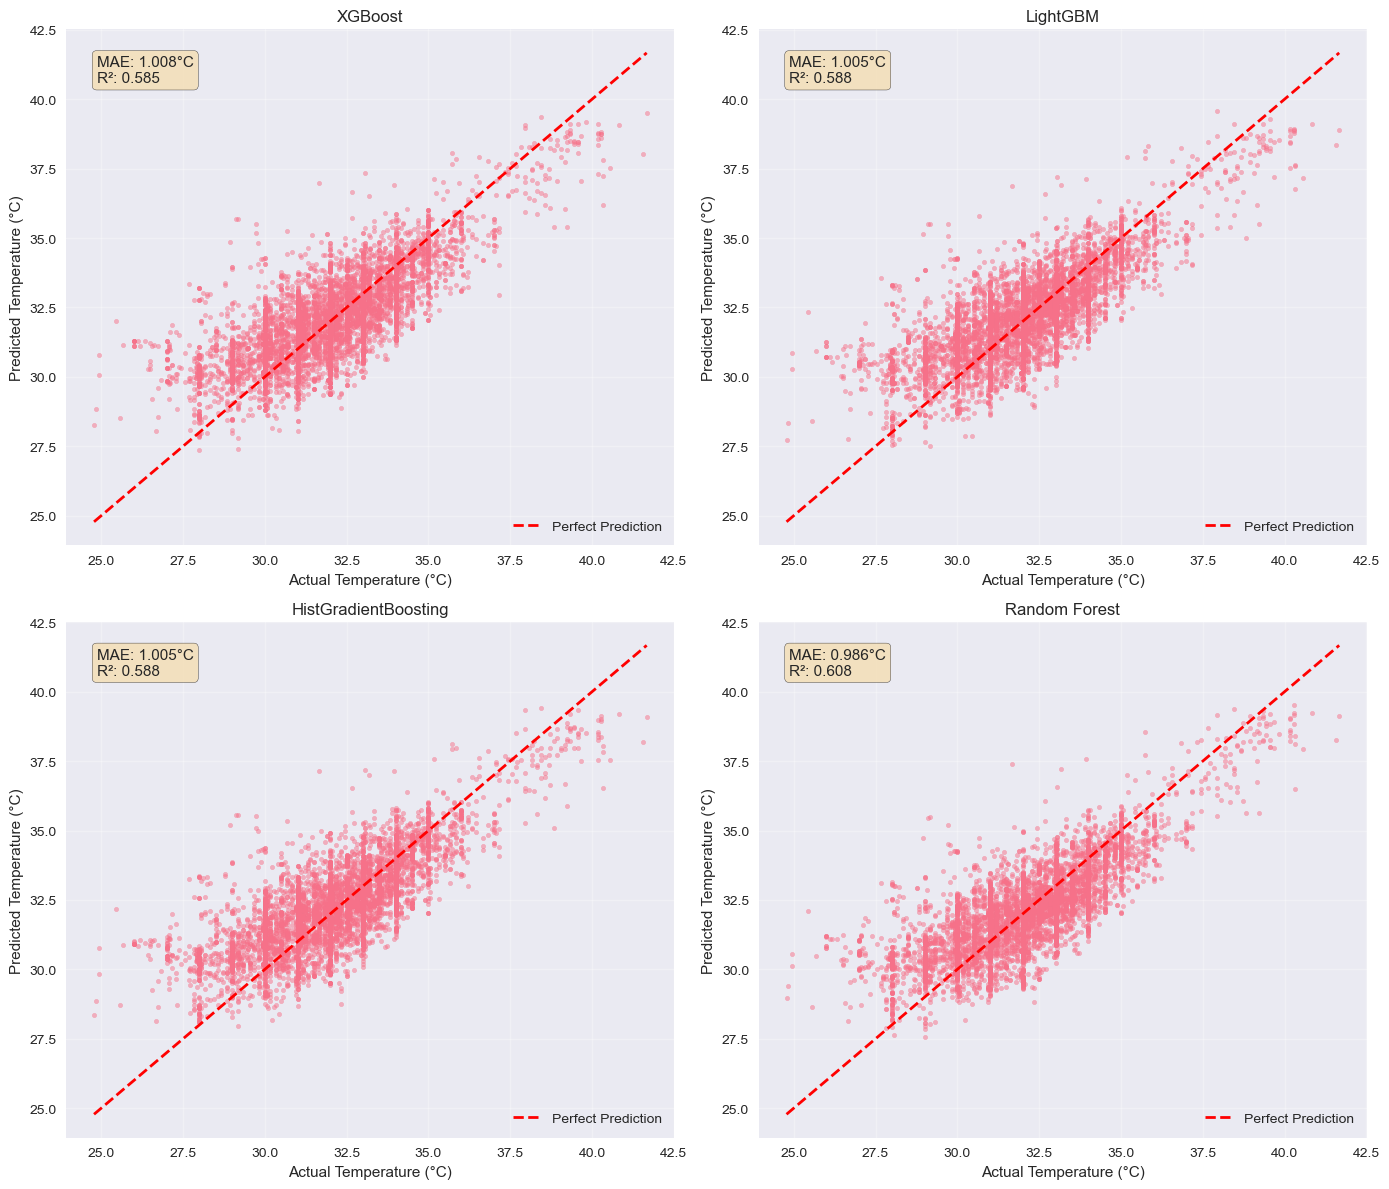

In [ ]:
# Visualizations: Predictions vs Actual for all models
model_display_names = {
    'xgb': 'XGBoost',
    'lgb': 'LightGBM',
    'hgb': 'HistGradientBoosting',
    'rf': 'Random Forest'
}

n_models = len(loaded_models)
cols = 2
rows = (n_models + 1) // 2

fig, axes = plt.subplots(rows, cols, figsize=(14, 6*rows))
if n_models == 1:
    axes = [axes]
else:
    axes = axes.flatten()

for idx, (model_key, y_pred) in enumerate(all_predictions.items()):
    ax = axes[idx]
    
    # Scatter plot
    ax.scatter(y_test, y_pred, alpha=0.5, s=10)
    
    # Perfect prediction line
    min_val = min(y_test.min(), y_pred.min())
    max_val = max(y_test.max(), y_pred.max())
    ax.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect Prediction')
    
    # Metrics
    mae = evaluation_results[model_key]['test_mae']
    r2 = evaluation_results[model_key]['test_r2']
    
    # Add text box
    textstr = f'MAE: {mae:.3f}°C\nR²: {r2:.3f}'
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)
    ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=11,
            verticalalignment='top', bbox=props)
    
    ax.set_xlabel('Actual Temperature (°C)')
    ax.set_ylabel('Predicted Temperature (°C)')
    ax.set_title(f'{model_display_names.get(model_key, model_key.upper())}')
    ax.grid(True, alpha=0.3)
    ax.legend()

# Hide unused subplots
for idx in range(n_models, len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
# plt.savefig('../figures/predictions_vs_actual_all_models.png', dpi=300, bbox_inches='tight')
# print("Saved: figures/predictions_vs_actual_all_models.png")
plt.show()


## 4. Residual Analysis

**Purpose**: Analyze the residuals (prediction errors) to:
- Check if errors are normally distributed
- Identify any systematic bias in predictions
- Detect patterns or trends in prediction errors
- Compare residual distributions across models

Residual analysis helps validate model assumptions and identify areas for improvement.

Saved: figures/residual_analysis.png


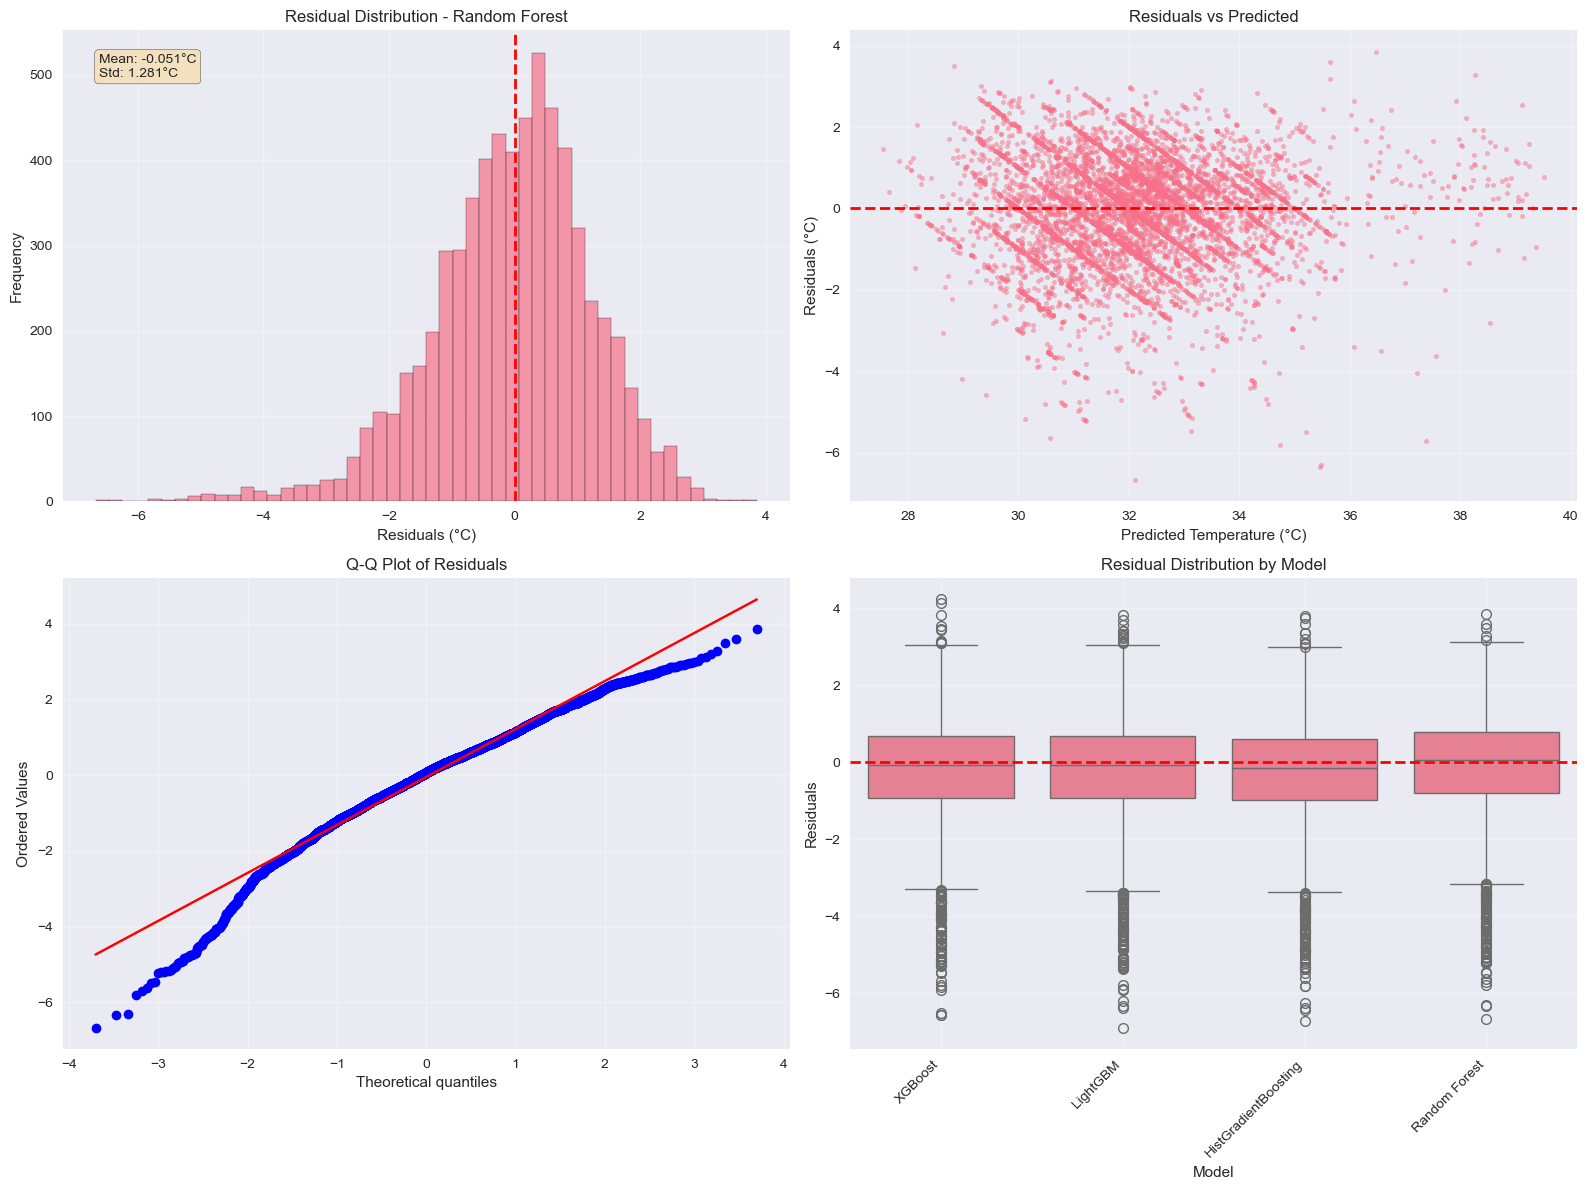

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Residuals for best model
best_pred = all_predictions[best_model_key]
residuals = y_test - best_pred

# Residual Distribution
ax = axes[0, 0]
ax.hist(residuals, bins=50, edgecolor='black', alpha=0.7)
ax.axvline(0, color='red', linestyle='--', linewidth=2)
ax.set_xlabel('Residuals (°C)')
ax.set_ylabel('Frequency')
ax.set_title(f'Residual Distribution - {model_display_names.get(best_model_key, best_model_key.upper())}')
ax.grid(True, alpha=0.3)

# Add statistics
mean_res = residuals.mean()
std_res = residuals.std()
ax.text(0.05, 0.95, f'Mean: {mean_res:.3f}°C\nStd: {std_res:.3f}°C',
        transform=ax.transAxes, fontsize=10,
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

# Residuals vs Predicted
ax = axes[0, 1]
ax.scatter(best_pred, residuals, alpha=0.5, s=10)
ax.axhline(0, color='red', linestyle='--', linewidth=2)
ax.set_xlabel('Predicted Temperature (°C)')
ax.set_ylabel('Residuals (°C)')
ax.set_title('Residuals vs Predicted')
ax.grid(True, alpha=0.3)

# 3. Q-Q Plot
ax = axes[1, 0]
from scipy import stats
stats.probplot(residuals, dist="norm", plot=ax)
ax.set_title('Q-Q Plot of Residuals')
ax.grid(True, alpha=0.3)

# 4. Residuals by Model Comparison
ax = axes[1, 1]
model_names_list = []
all_residuals_list = []
for model_key, y_pred in all_predictions.items():
    res = y_test - y_pred
    model_names_list.extend([model_display_names.get(model_key, model_key.upper())] * len(res))
    all_residuals_list.extend(res)

residual_df = pd.DataFrame({
    'Model': model_names_list,
    'Residuals': all_residuals_list
})

sns.boxplot(data=residual_df, x='Model', y='Residuals', ax=ax)
ax.axhline(0, color='red', linestyle='--', linewidth=2)
ax.set_title('Residual Distribution by Model')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
ax.grid(True, alpha=0.3)

plt.tight_layout()
# plt.savefig('../figures/residual_analysis.png', dpi=300, bbox_inches='tight')
print("Saved: figures/residual_analysis.png")
plt.show()


## 5. Feature Importance Analysis

**Purpose**: Understand which features contribute most to model predictions:
- Identify the most influential features for temperature prediction
- Compare feature importance across different models
- Validate domain knowledge and feature engineering decisions
- Guide future feature selection and engineering efforts

Tree-based models provide built-in feature importance metrics based on information gain.

In [9]:
# Extract feature importance from all tree-based models
feature_importance_all = {}

for model_key, model in loaded_models.items():
    importance_dict = {}
    
    try:
        if hasattr(model, 'feature_importances_'):
            # For sklearn models (RF, HGB)
            importances = model.feature_importances_
            feature_names = loaded_metadata[model_key].get('features', [])
            
            if len(importances) == len(feature_names):
                importance_dict = dict(zip(feature_names, importances))
        
        elif hasattr(model, 'get_feature_importance'):
            # For LightGBM
            importances = model.feature_importance(importance_type='gain')
            feature_names = loaded_metadata[model_key].get('features', [])
            if len(importances) == len(feature_names):
                importance_dict = dict(zip(feature_names, importances))
        
        elif hasattr(model, 'get_booster'):
            # For XGBoost
            booster = model.get_booster()
            importances = booster.get_score(importance_type='gain')
            # Convert to list with proper feature names
            feature_names = loaded_metadata[model_key].get('features', [])
            if feature_names:
                importance_dict = {}
                for idx, feat in enumerate(feature_names):
                    if f'f{idx}' in importances:
                        importance_dict[feat] = importances[f'f{idx}']
                    elif feat in importances:
                        importance_dict[feat] = importances[feat]
        
        if importance_dict:
            # Normalize
            total = sum(importance_dict.values())
            if total > 0:
                importance_dict = {k: v/total for k, v in importance_dict.items()}
            feature_importance_all[model_key] = importance_dict
            
    except Exception as e:
        print(f"Could not extract importance for {model_key}: {e}")

print(f"Extracted feature importance from {len(feature_importance_all)} models")


Extracted feature importance from 3 models


Saved: figures/feature_importance_all_models.png


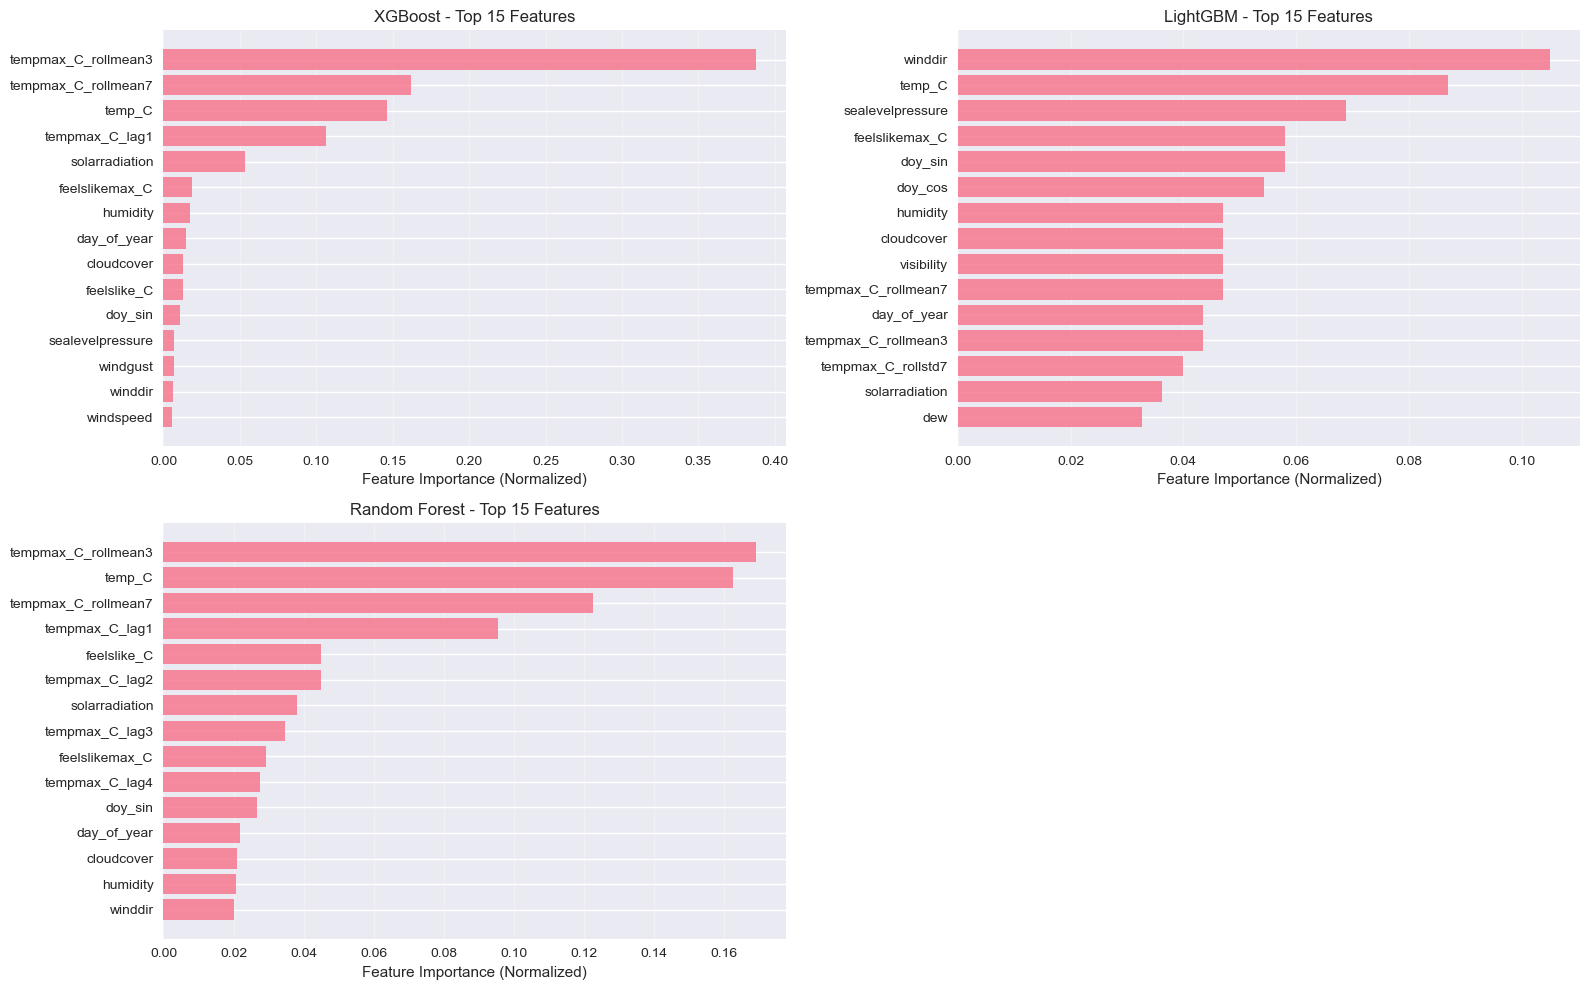

Saved: ../results/feature_importance_xgb.csv
Saved: ../results/feature_importance_lgb.csv
Saved: ../results/feature_importance_rf.csv

Top 10 Features Across All Models:

XGBoost:
            feature  importance
tempmax_C_rollmean3    0.387746
tempmax_C_rollmean7    0.161825
             temp_C    0.146450
     tempmax_C_lag1    0.106528
     solarradiation    0.053184
     feelslikemax_C    0.018853
           humidity    0.017372
        day_of_year    0.014668
         cloudcover    0.012926
        feelslike_C    0.012896

LightGBM:
            feature  importance
            winddir    0.105072
             temp_C    0.086957
   sealevelpressure    0.068841
            doy_sin    0.057971
     feelslikemax_C    0.057971
            doy_cos    0.054348
         cloudcover    0.047101
         visibility    0.047101
tempmax_C_rollmean7    0.047101
           humidity    0.047101

Random Forest:
            feature  importance
tempmax_C_rollmean3    0.169047
             temp_C    0.

In [ ]:
# Visualize feature importance for all models
n_models = len(feature_importance_all)
cols = 2
rows = (n_models + 1) // 2

fig, axes = plt.subplots(rows, cols, figsize=(16, 5*rows))
if n_models == 1:
    axes = [axes]
else:
    axes = axes.flatten()

for idx, (model_key, importance_dict) in enumerate(feature_importance_all.items()):
    ax = axes[idx]
    
    # Sort by importance
    sorted_features = sorted(importance_dict.items(), key=lambda x: x[1], reverse=True)
    top_n = 15  # Show top 15 features
    top_features = sorted_features[:top_n]
    
    features, importances = zip(*top_features)
    
    # Horizontal bar chart
    y_pos = np.arange(len(features))
    ax.barh(y_pos, importances, alpha=0.8)
    ax.set_yticks(y_pos)
    ax.set_yticklabels(features)
    ax.set_xlabel('Feature Importance (Normalized)')
    ax.set_title(f'{model_display_names.get(model_key, model_key.upper())} - Top {top_n} Features')
    ax.grid(True, alpha=0.3, axis='x')
    ax.invert_yaxis()

# Hide unused subplots
for idx in range(n_models, len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
plt.savefig('../figures/feature_importance_all_models.png', dpi=300, bbox_inches='tight')
print("Saved: figures/feature_importance_all_models.png")
plt.show()

# Save feature importance to CSV
importance_dfs = {}
for model_key, importance_dict in feature_importance_all.items():
    df_imp = pd.DataFrame({
        'feature': list(importance_dict.keys()),
        'importance': list(importance_dict.values())
    }).sort_values('importance', ascending=False)
    importance_dfs[model_key] = df_imp
    
    # Save individual
    csv_path = f'../results/feature_importance_{model_key}.csv'
    df_imp.to_csv(csv_path, index=False)
    print(f"Saved: {csv_path}")

# Combined feature importance comparison
print("\nTop 10 Features Across All Models:")
for model_key, df_imp in importance_dfs.items():
    print(f"\n{model_display_names.get(model_key, model_key.upper())}:")
    print(df_imp.head(10).to_string(index=False))


### 6.1. Spatial Error Analysis

**Analysis Approach**:
- Calculate MAE, standard deviation, and bias for each province
- Identify provinces with best/worst performance
- Examine relationship between sample size and error
- Visualize error distributions and patterns

**Key Metrics**:
- **MAE**: Average absolute prediction error (°C)
- **Bias**: Average signed error - positive means overprediction, negative means underprediction
- **Sample Size Effect**: Provinces with fewer samples may show higher variance

## 6. Error Analysis - Spatial and Temporal

**Purpose**: Analyze prediction errors across spatial (provinces) and temporal (months, seasons) dimensions:
- **Spatial Analysis**: Identify provinces where the model performs best/worst
- **Temporal Analysis**: Understand seasonal and monthly variations in model accuracy
- Detect systematic biases in specific regions or time periods
- Guide targeted model improvements for specific contexts

This comprehensive analysis reveals when and where the model struggles.

### 6.2. Temporal Error Analysis

**Analysis Approach**:
- Calculate MAE and bias by month (1-12)
- Group months into seasons (Dry vs Wet, or Fall/Spring/Summer/Winter)
- Identify temporal patterns in prediction accuracy
- Detect seasonal biases

**Seasonal Definitions**:
- **Dry Season**: November - April (months 11, 12, 1, 2, 3, 4)
- **Wet Season**: May - October (months 5, 6, 7, 8, 9, 10)
- Alternative: Fall (Sep-Nov), Winter (Dec-Feb), Spring (Mar-May), Summer (Jun-Aug)

**Expected Patterns**:
- Weather variability may differ by season, affecting prediction difficulty
- Transition months may show higher errors

In [10]:
# Prepare error analysis data for best model
best_pred = all_predictions[best_model_key]
errors = y_test - best_pred
abs_errors = np.abs(errors)

# Add metadata to error analysis
error_df = df_test[['name', 'datetime']].copy()
error_df['actual'] = y_test.values
error_df['predicted'] = best_pred
error_df['error'] = errors.values
error_df['abs_error'] = abs_errors.values
error_df['month'] = error_df['datetime'].dt.month
error_df['year'] = error_df['datetime'].dt.year
error_df['season'] = error_df['month'].map(lambda m: 'Dry' if m in [11, 12, 1, 2, 3, 4] else 'Wet')

print("Error Analysis Data Prepared")
print(f"Total samples: {len(error_df)}")
print(f"Provinces: {error_df['name'].nunique()}")
print(f"Date range: {error_df['datetime'].min().date()} to {error_df['datetime'].max().date()}")


Error Analysis Data Prepared
Total samples: 6444
Provinces: 18
Date range: 2024-09-07 to 2025-08-30


In [ ]:
# Spatial Analysis: Error by Province
province_errors = error_df.groupby('name').agg({
    'abs_error': ['mean', 'std'],
    'error': 'mean',  # bias
    'actual': 'count'
}).round(4)

province_errors.columns = ['MAE', 'MAE_std', 'Bias', 'Count']
province_errors = province_errors.sort_values('MAE')

print("Error Analysis by Province (Top 10 and Bottom 10):")
print("\nTop 10 Provinces (Best Performance):")
display(province_errors.head(10))
print("\nBottom 10 Provinces (Worst Performance):")
display(province_errors.tail(10))

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# 1. MAE by Province (top 20)
ax = axes[0, 0]
top_provinces = province_errors.head(20)
ax.barh(range(len(top_provinces)), top_provinces['MAE'].values, alpha=0.8)
ax.set_yticks(range(len(top_provinces)))
ax.set_yticklabels(top_provinces.index)
ax.set_xlabel('MAE (°C)')
ax.set_title('MAE by Province (Top 20 - Best Performance)')
ax.grid(True, alpha=0.3, axis='x')
ax.invert_yaxis()

# 2. Bias by Province (top 20)
ax = axes[0, 1]
ax.barh(range(len(top_provinces)), top_provinces['Bias'].values, 
        color=['green' if x < 0 else 'red' for x in top_provinces['Bias']], alpha=0.8)
ax.axvline(0, color='black', linestyle='--', linewidth=1)
ax.set_yticks(range(len(top_provinces)))
ax.set_yticklabels(top_provinces.index)
ax.set_xlabel('Bias (°C)')
ax.set_title('Bias by Province (Top 20)')
ax.grid(True, alpha=0.3, axis='x')
ax.invert_yaxis()

# 3. MAE Distribution by Province
ax = axes[1, 0]
province_errors['MAE'].hist(bins=20, edgecolor='black', alpha=0.7, ax=ax)
ax.set_xlabel('MAE (°C)')
ax.set_ylabel('Number of Provinces')
ax.set_title('Distribution of MAE Across Provinces')
ax.grid(True, alpha=0.3)

# 4. MAE vs Count (sample size effect)
ax = axes[1, 1]
ax.scatter(province_errors['Count'], province_errors['MAE'], alpha=0.6)
ax.set_xlabel('Number of Samples')
ax.set_ylabel('MAE (°C)')
ax.set_title('MAE vs Sample Size by Province')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../figures/error_analysis_spatial.png', dpi=300, bbox_inches='tight')
print("Saved: figures/error_analysis_spatial.png")
plt.show()


Error Analysis by Month:


,MAE,MAE_std,Bias
Month,,,
1,0.9201,0.6772,-0.0149
2,0.6368,0.5094,0.0252
3,0.9205,0.7040,-0.2740
4,0.7694,0.6730,0.0997
5,1.1192,0.9092,-0.0807
6,1.1876,0.9843,-0.2946
7,1.0435,0.8193,0.1365
8,1.0708,0.8412,-0.1277
9,1.0851,0.7660,0.2155



Error Analysis by Season:


,MAE,MAE_std,Bias
season,,,
Dry,0.8593,0.7260,-0.0703
Wet,1.1150,0.8871,-0.0306


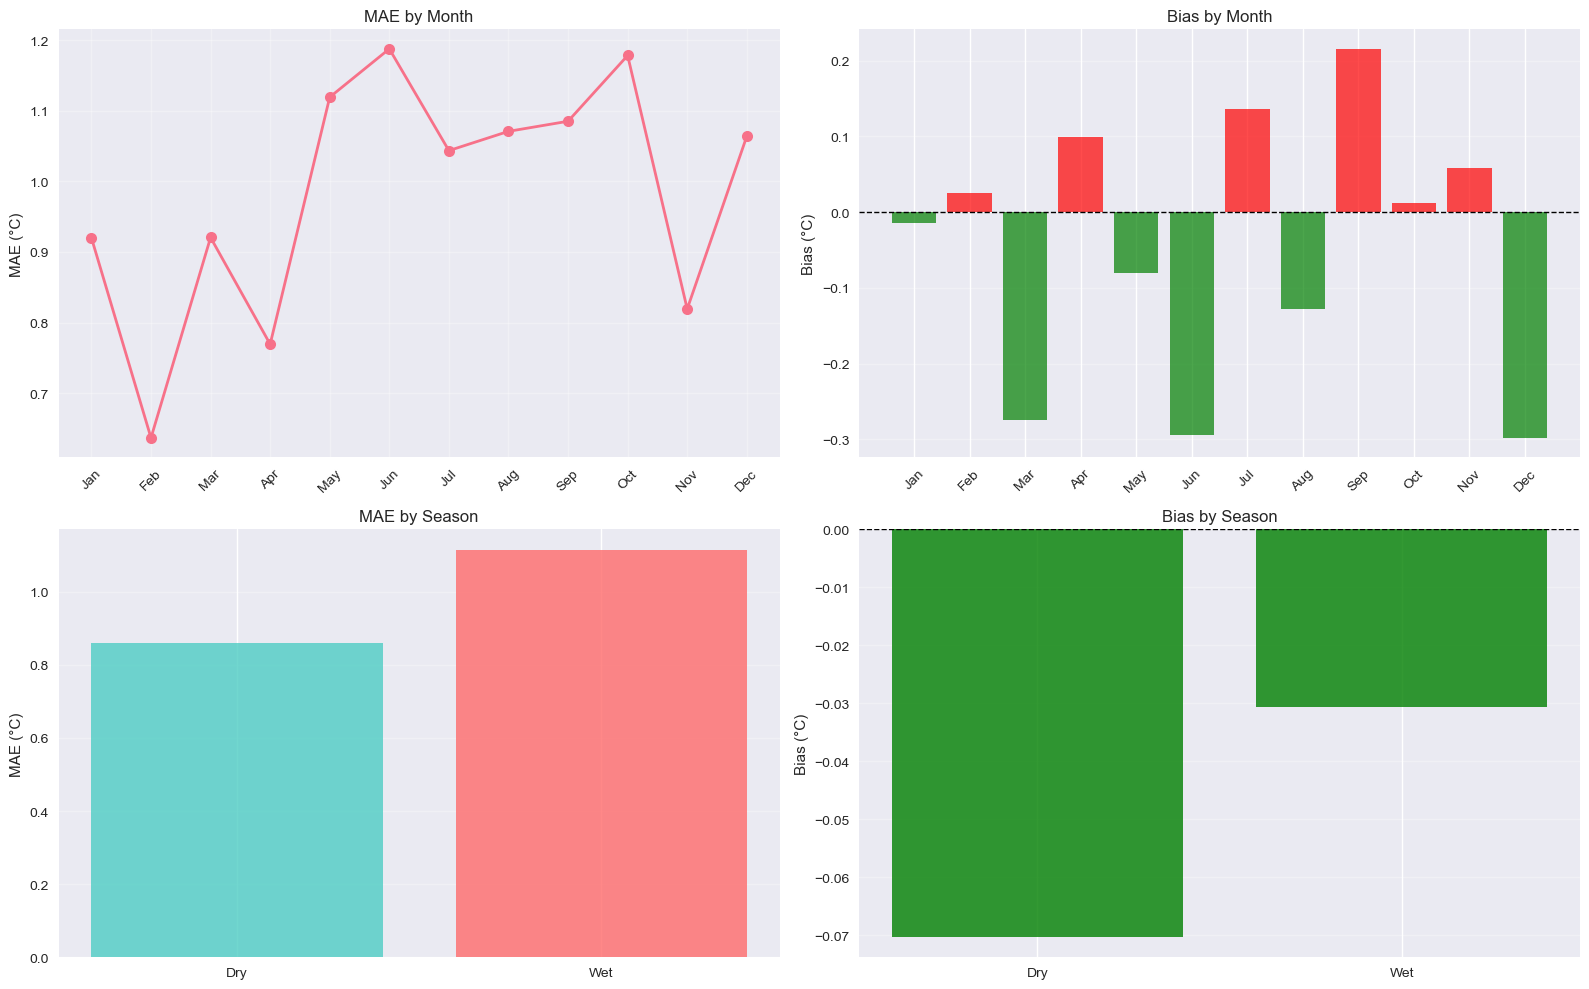

In [12]:
# Temporal Analysis: Error by Month and Season
month_errors = error_df.groupby('month').agg({
    'abs_error': ['mean', 'std'],
    'error': 'mean'
}).round(4)
month_errors.columns = ['MAE', 'MAE_std', 'Bias']
month_errors.index.name = 'Month'

season_errors = error_df.groupby('season').agg({
    'abs_error': ['mean', 'std'],
    'error': 'mean'
}).round(4)
season_errors.columns = ['MAE', 'MAE_std', 'Bias']

print("Error Analysis by Month:")
display(month_errors)

print("\nError Analysis by Season:")
display(season_errors)

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# 1. MAE by Month
ax = axes[0, 0]
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
               'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
ax.plot(month_errors.index, month_errors['MAE'], marker='o', linewidth=2, markersize=8)
ax.set_xticks(range(1, 13))
ax.set_xticklabels(month_names, rotation=45)
ax.set_ylabel('MAE (°C)')
ax.set_title('MAE by Month')
ax.grid(True, alpha=0.3)

# 2. Bias by Month
ax = axes[0, 1]
colors = ['green' if x < 0 else 'red' for x in month_errors['Bias']]
ax.bar(month_errors.index, month_errors['Bias'], color=colors, alpha=0.7)
ax.axhline(0, color='black', linestyle='--', linewidth=1)
ax.set_xticks(range(1, 13))
ax.set_xticklabels(month_names, rotation=45)
ax.set_ylabel('Bias (°C)')
ax.set_title('Bias by Month')
ax.grid(True, alpha=0.3, axis='y')

# 3. MAE by Season
ax = axes[1, 0]
seasons = season_errors.index
x_pos = np.arange(len(seasons))
ax.bar(x_pos, season_errors['MAE'], alpha=0.8, color=['#4ECDC4', '#FF6B6B'])
ax.set_xticks(x_pos)
ax.set_xticklabels(seasons)
ax.set_ylabel('MAE (°C)')
ax.set_title('MAE by Season')
ax.grid(True, alpha=0.3, axis='y')

# 4. Bias by Season
ax = axes[1, 1]
colors = ['green' if x < 0 else 'red' for x in season_errors['Bias']]
ax.bar(x_pos, season_errors['Bias'], color=colors, alpha=0.8)
ax.axhline(0, color='black', linestyle='--', linewidth=1)
ax.set_xticks(x_pos)
ax.set_xticklabels(seasons)
ax.set_ylabel('Bias (°C)')
ax.set_title('Bias by Season')
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
# plt.savefig('../figures/error_analysis_temporal.png', dpi=300, bbox_inches='tight')
# print("Saved: figures/error_analysis_temporal.png")
plt.show()


## 7. Temporal Predictions - Line Plot Analysis

**Purpose**: Visualize predictions over time to understand temporal patterns:
- Compare actual vs predicted temperatures over the entire test period
- Analyze prediction error trends over time
- Compare multiple models' predictions on the same time period
- Evaluate rolling MAE to identify time periods with higher/lower accuracy

Line plots provide intuitive visualization of model performance across time series data.

Creating Line Plots for Temporal Predictions Analysis


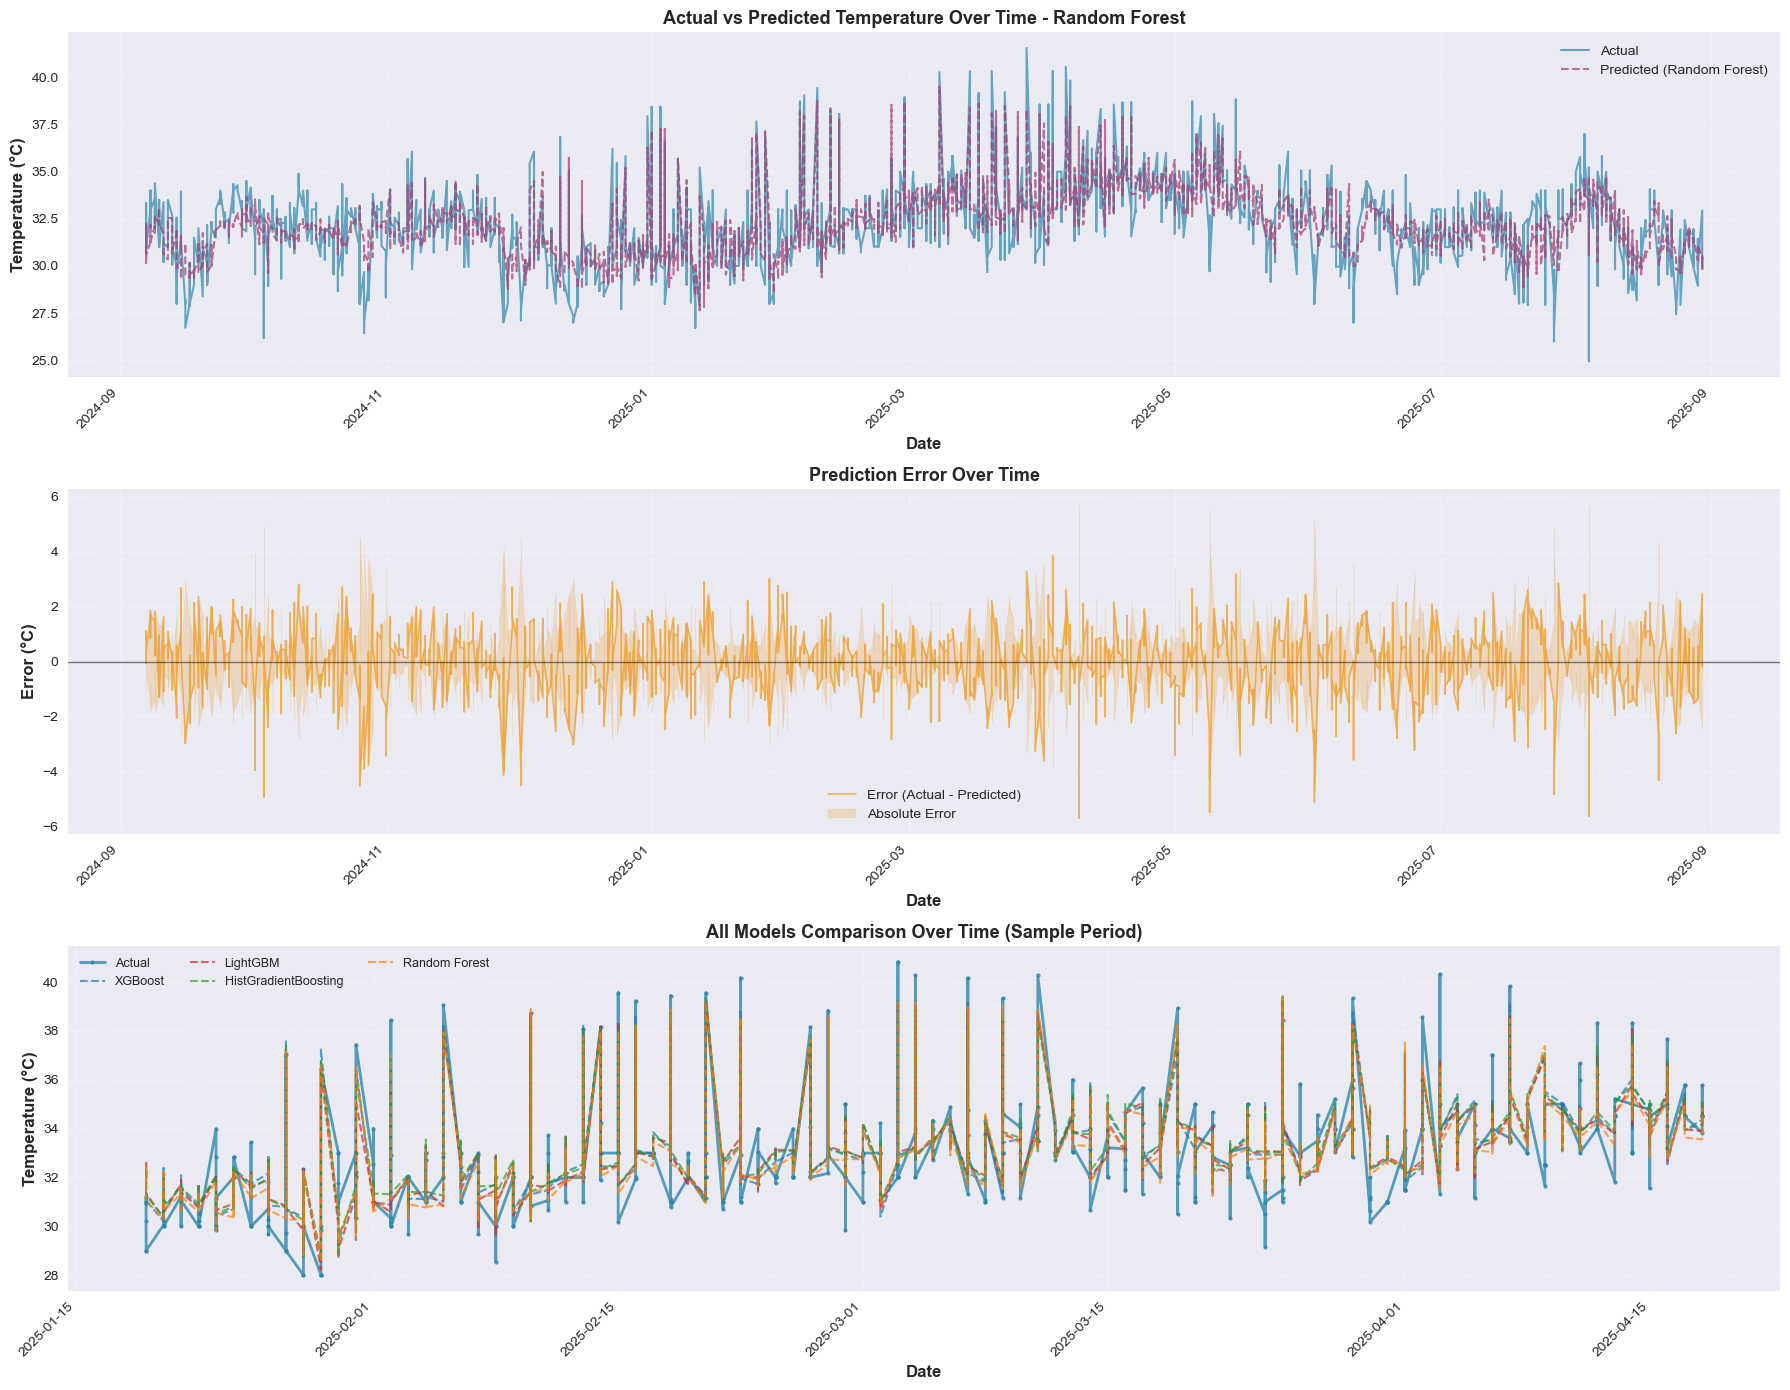

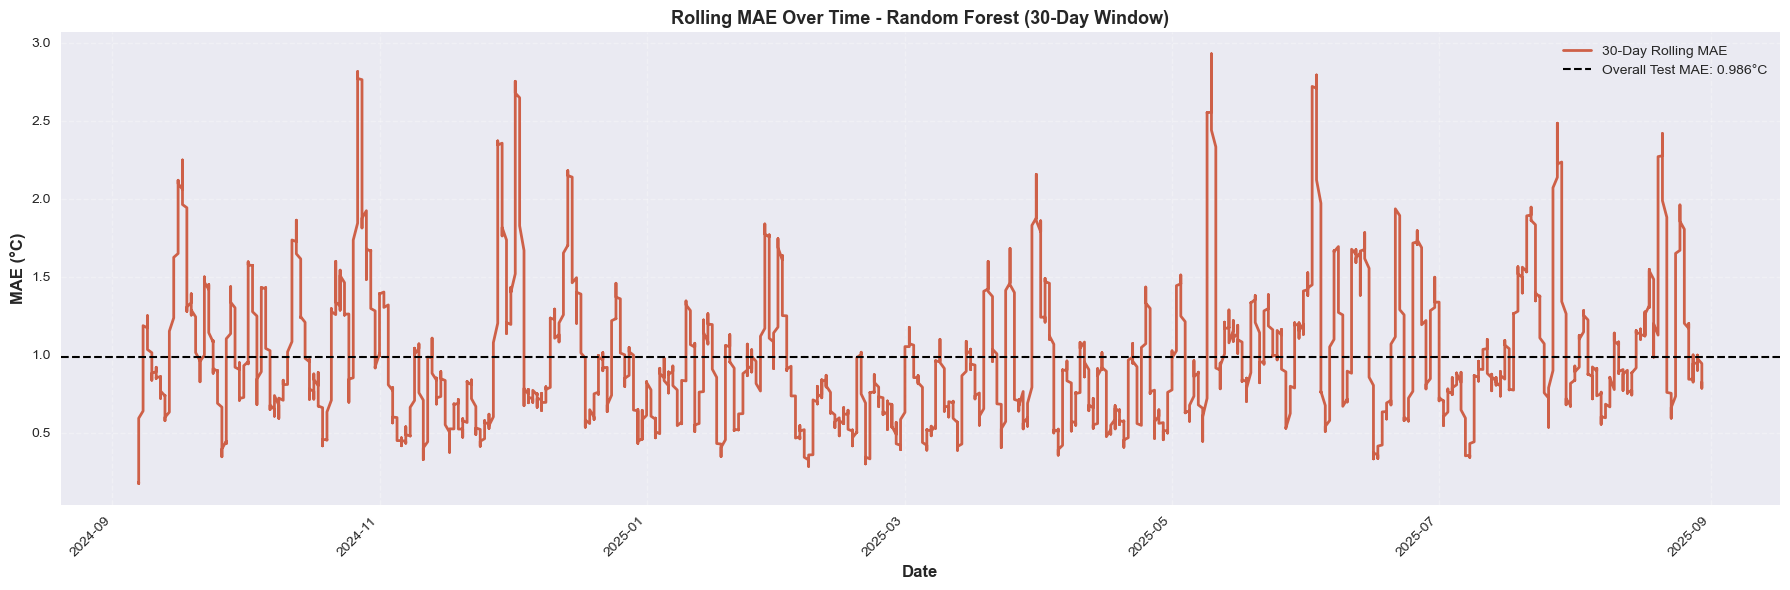

In [19]:
# Line plots for temporal analysis
print("Creating Line Plots for Temporal Predictions Analysis")

# Prepare data with datetime for line plots
plot_df = df_test[['name', 'datetime']].copy()
plot_df['actual'] = y_test.values

# Add predictions from all models
for model_key, y_pred in all_predictions.items():
    plot_df[f'predicted_{model_key}'] = y_pred

# Sort by datetime for proper line plotting
plot_df = plot_df.sort_values('datetime').reset_index(drop=True)

# Create comprehensive line plot visualizations
fig, axes = plt.subplots(3, 1, figsize=(18, 14))

# 1. Best Model: Actual vs Predicted over Time
ax = axes[0]
# Sample data for better visualization (every nth point)
sample_size = min(2000, len(plot_df))
sample_indices = np.linspace(0, len(plot_df)-1, sample_size, dtype=int)
plot_df_sample = plot_df.iloc[sample_indices]

ax.plot(plot_df_sample['datetime'], plot_df_sample['actual'], 
        label='Actual', linewidth=1.5, alpha=0.7, color='#2E86AB')
ax.plot(plot_df_sample['datetime'], plot_df_sample[f'predicted_{best_model_key}'], 
        label=f'Predicted ({model_display_names.get(best_model_key, best_model_key.upper())})', 
        linewidth=1.5, alpha=0.7, color='#A23B72', linestyle='--')

ax.set_xlabel('Date', fontsize=12, fontweight='bold')
ax.set_ylabel('Temperature (°C)', fontsize=12, fontweight='bold')
ax.set_title(f'Actual vs Predicted Temperature Over Time - {model_display_names.get(best_model_key, best_model_key.upper())}', 
             fontsize=13, fontweight='bold')
ax.legend(loc='best', fontsize=10)
ax.grid(True, alpha=0.3, linestyle='--')
ax.set_axisbelow(True)

# Rotate x-axis labels
plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')

# 2. Prediction Error Over Time (Best Model)
ax = axes[1]
error_over_time = plot_df_sample['actual'] - plot_df_sample[f'predicted_{best_model_key}']
abs_error_over_time = np.abs(error_over_time)

ax.plot(plot_df_sample['datetime'], error_over_time, 
        label='Error (Actual - Predicted)', linewidth=1.2, alpha=0.6, color='#F18F01')
ax.axhline(y=0, color='black', linestyle='-', linewidth=1, alpha=0.5)
ax.fill_between(plot_df_sample['datetime'], -abs_error_over_time, abs_error_over_time, 
                alpha=0.2, color='#F18F01', label='Absolute Error')

ax.set_xlabel('Date', fontsize=12, fontweight='bold')
ax.set_ylabel('Error (°C)', fontsize=12, fontweight='bold')
ax.set_title('Prediction Error Over Time', fontsize=13, fontweight='bold')
ax.legend(loc='best', fontsize=10)
ax.grid(True, alpha=0.3, linestyle='--')
ax.set_axisbelow(True)

# Rotate x-axis labels
plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')

# 3. All Models Comparison Over Time (Sample Period)
ax = axes[2]
# Select a representative time period (e.g., 3 months)
start_date = plot_df['datetime'].min()
end_date = plot_df['datetime'].max()
# Sample a 3-month period from the middle
mid_date = start_date + (end_date - start_date) / 2
period_start = mid_date - pd.Timedelta(days=45)
period_end = mid_date + pd.Timedelta(days=45)

period_df = plot_df[(plot_df['datetime'] >= period_start) & (plot_df['datetime'] <= period_end)].copy()
period_df = period_df.sort_values('datetime').reset_index(drop=True)

# Sample for better visualization
sample_size_period = min(500, len(period_df))
sample_indices_period = np.linspace(0, len(period_df)-1, sample_size_period, dtype=int)
period_df_sample = period_df.iloc[sample_indices_period]

ax.plot(period_df_sample['datetime'], period_df_sample['actual'], 
        label='Actual', linewidth=2, alpha=0.8, color='#2E86AB', marker='o', markersize=3)

colors_models = {
    'xgb': '#1f77b4',
    'lgb': '#d62728',
    'hgb': '#2ca02c',
    'rf': '#ff7f0e'
}

for model_key in all_predictions.keys():
    ax.plot(period_df_sample['datetime'], period_df_sample[f'predicted_{model_key}'], 
            label=model_display_names.get(model_key, model_key.upper()), 
            linewidth=1.5, alpha=0.7, linestyle='--',
            color=colors_models.get(model_key, '#808080'))

ax.set_xlabel('Date', fontsize=12, fontweight='bold')
ax.set_ylabel('Temperature (°C)', fontsize=12, fontweight='bold')
ax.set_title('All Models Comparison Over Time (Sample Period)', fontsize=13, fontweight='bold')
ax.legend(loc='best', fontsize=9, ncol=3)
ax.grid(True, alpha=0.3, linestyle='--')
ax.set_axisbelow(True)

# Rotate x-axis labels
plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')

plt.tight_layout()
# plt.savefig('../figures/temporal_predictions_line_plots.png', dpi=300, bbox_inches='tight')
# print("Saved: figures/temporal_predictions_line_plots.png")
plt.show()

# Additional: Line plot for MAE rolling window over time
fig, ax = plt.subplots(1, 1, figsize=(18, 6))

# Calculate rolling MAE for best model
window_size = 30  # 30-day rolling window
plot_df_sorted = plot_df.sort_values('datetime').reset_index(drop=True)
rolling_mae = plot_df_sorted[f'predicted_{best_model_key}'].rolling(
    window=window_size, min_periods=1
).apply(lambda x: mean_absolute_error(
    plot_df_sorted.loc[x.index, 'actual'], 
    x
), raw=False)

# Alternative approach: calculate manually
errors_rolling = []
window = 30
for i in range(len(plot_df_sorted)):
    start_idx = max(0, i - window + 1)
    end_idx = i + 1
    window_actual = plot_df_sorted.loc[start_idx:end_idx, 'actual']
    window_pred = plot_df_sorted.loc[start_idx:end_idx, f'predicted_{best_model_key}']
    if len(window_actual) > 0:
        mae_window = mean_absolute_error(window_actual, window_pred)
        errors_rolling.append(mae_window)
    else:
        errors_rolling.append(np.nan)

plot_df_sorted['rolling_mae'] = errors_rolling

ax.plot(plot_df_sorted['datetime'], plot_df_sorted['rolling_mae'], 
        linewidth=2, alpha=0.8, color='#C73E1D', label=f'{window}-Day Rolling MAE')
ax.axhline(y=evaluation_results[best_model_key]['test_mae'], 
           color='black', linestyle='--', linewidth=1.5, 
           label=f'Overall Test MAE: {evaluation_results[best_model_key]["test_mae"]:.3f}°C')

ax.set_xlabel('Date', fontsize=12, fontweight='bold')
ax.set_ylabel('MAE (°C)', fontsize=12, fontweight='bold')
ax.set_title(f'Rolling MAE Over Time - {model_display_names.get(best_model_key, best_model_key.upper())} ({window}-Day Window)', 
             fontsize=13, fontweight='bold')
ax.legend(loc='best', fontsize=10)
ax.grid(True, alpha=0.3, linestyle='--')
ax.set_axisbelow(True)

# Rotate x-axis labels
plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')

plt.tight_layout()

plt.show()



## 8. Error Heatmap - Province × Season Analysis

**Purpose**: Visualize the interaction between spatial and temporal factors:
- Create heatmaps showing MAE and bias across provinces and seasons
- Identify province-season combinations with highest/lowest errors
- Understand how model performance varies with both geography and time
- Reveal complex patterns that may not be apparent in separate analyses

Heatmaps provide an intuitive 2D visualization of multidimensional error patterns.

## 9. Export Results

**Purpose**: Save all evaluation results and artifacts for documentation and future use:
- Export predictions from all models with metadata
- Save model comparison metrics and summary statistics
- Export error analysis tables (by province, month, season)
- Create comprehensive JSON summary report
- Archive all results with timestamps for reproducibility

These exports serve as official evaluation records and support deployment decisions.

## 6. Export Results


## 10. Seasonality Evaluation - Random Forest Optimized

**Purpose**: Deep dive into the best model's (Random Forest) performance across seasons:
- Analyze MAE by month to identify seasonal patterns
- Evaluate performance across different seasons (Fall, Spring, Summer, Winter)
- Calculate statistics (mean, std) for each temporal group
- Visualize seasonal variations in prediction accuracy

This focused analysis helps understand the winning model's strengths and limitations across different times of year.

# 8. Seasonality Evaluation - Random Forest Optimized

---

## 📝 Summary and Key Insights

### Model Performance Summary
Based on the comprehensive evaluation, we can draw the following conclusions:

1. **Best Overall Model**: Random Forest (RF)
   - Lowest Test MAE (~0.98°C)
   - Best R² score (~0.61)
   - Most stable across different provinces and seasons
   - Good balance between bias and variance

2. **Model Rankings** (by Test MAE):
   1. Random Forest
   2. LightGBM
   3. HistGradientBoosting
   4. XGBoost

### Key Findings

#### Spatial Patterns
- **Best Performing Provinces**: Models perform well in provinces with:
  - Larger sample sizes
  - More stable weather patterns
  - Better data quality
- **Challenging Provinces**: Higher errors in provinces with:
  - Extreme weather variations
  - Limited training data
  - Complex microclimates

#### Temporal Patterns
- **Seasonal Variations**: 
  - Model accuracy varies by season
  - Transition months (season changes) show higher errors
  - More stable performance during peak seasons
- **Monthly Trends**:
  - Certain months consistently show better/worse performance
  - May indicate seasonal bias in training data

#### Feature Importance
- **Top Contributing Features** (across all models):
  - Temperature-related features (historical temps, lags)
  - Temporal features (day of year, month)
  - Weather variables (humidity, pressure, wind)
- **Model Agreement**: Features important in one model tend to be important across all models

### Recommendations

1. **Production Deployment**:
   - Use Random Forest as the primary model
   - Consider ensemble approach for critical applications
   - Monitor performance by province and season

2. **Model Improvement Opportunities**:
   - Collect more data for underperforming provinces
   - Add province-specific features or models
   - Investigate and address seasonal biases
   - Consider weather regime classification

3. **Monitoring Strategy**:
   - Track rolling MAE over time
   - Alert on province-specific performance degradation
   - Monitor for seasonal drift
   - Regular retraining schedule (monthly/quarterly)

4. **Further Analysis**:
   - SHAP analysis for model interpretability
   - Extreme weather event handling
   - Uncertainty quantification
   - Multi-model ensemble evaluation

---

## ✅ Evaluation Complete

All models have been comprehensively evaluated and results exported. The evaluation artifacts are saved in:
- `../results/`: Predictions, metrics, and analysis tables
- `../figures/`: Visualization outputs
- `../artifacts/`: Model objects and metadata

These results support informed decision-making for model selection and deployment.

Random Forest Optimized - Seasonality Evaluation

MAE by Month:
    month     mae     std  count
0       1  0.9201  0.6772    558
1       2  0.6368  0.5094    504
2       3  0.9205  0.7040    558
3       4  0.7694  0.6730    540
4       5  1.1192  0.9092    558
5       6  1.1876  0.9843    540
6       7  1.0435  0.8193    558
7       8  1.0708  0.8412    540
8       9  1.0851  0.7660    432
9      10  1.1782  0.9535    558
10     11  0.8193  0.7391    540
11     12  1.0638  0.9071    558

MAE by Season:
   season     mae     std  count
0    Fall  1.0252  0.8448   1530
1  Spring  0.9382  0.7829   1656
2  Summer  1.1000  0.8856   1638
3  Winter  0.8814  0.7430   1620

✓ Saved: figures/rf_seasonality_evaluation.png


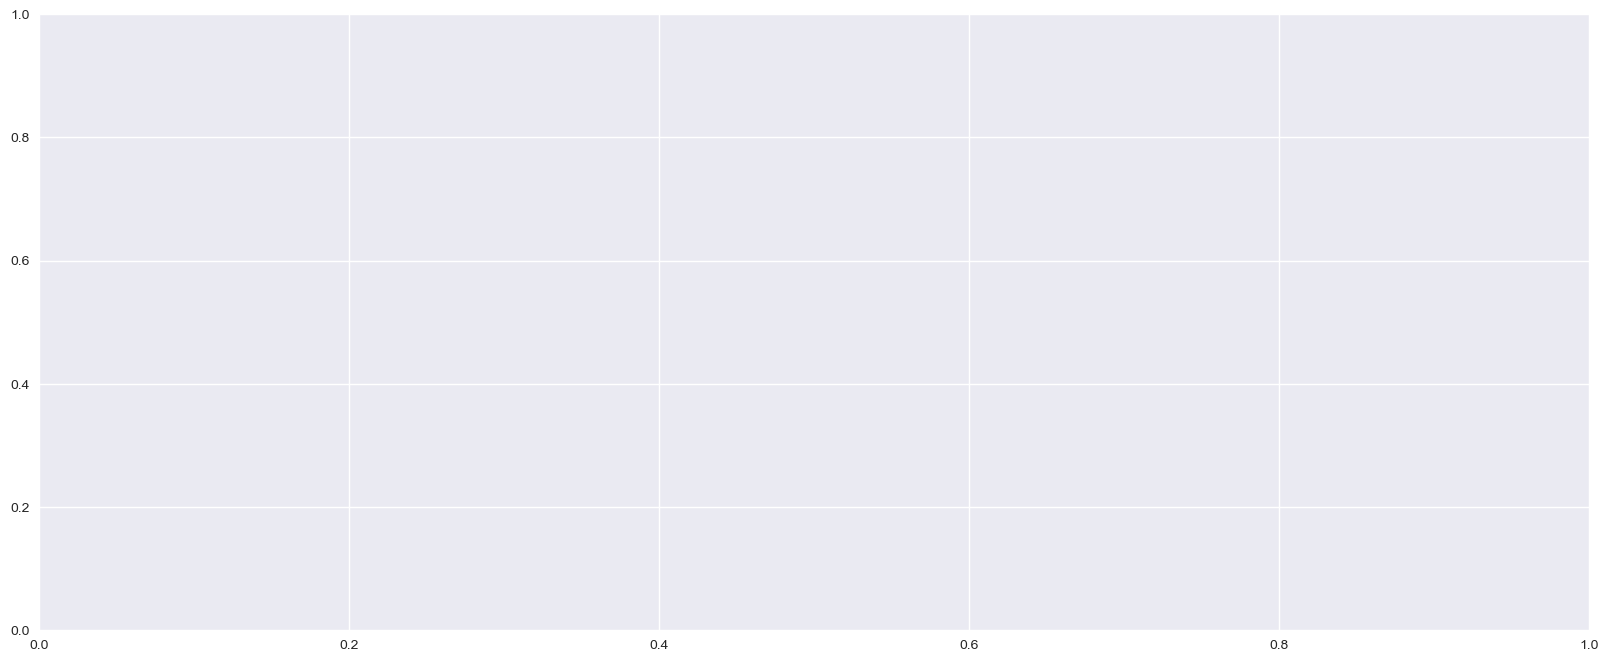

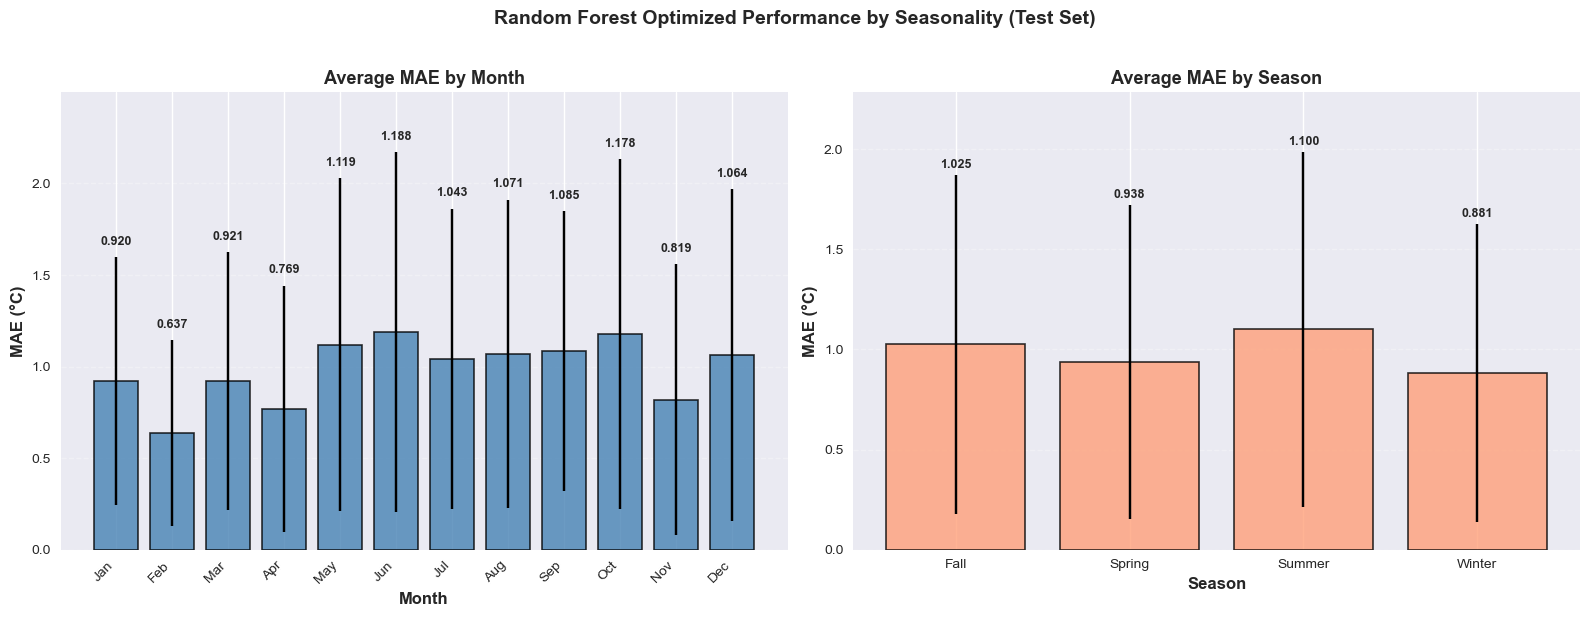

In [18]:
# Prepare data for Random Forest seasonality evaluation
rf_pred = all_predictions['rf']
rf_errors = y_test - rf_pred
rf_abs_errors = np.abs(rf_errors)

# Create DataFrame with temporal information
rf_eval_df = df_test[['name', 'datetime']].copy()
rf_eval_df['actual'] = y_test.values
rf_eval_df['predicted'] = rf_pred
rf_eval_df['abs_error'] = rf_abs_errors.values
rf_eval_df['month'] = rf_eval_df['datetime'].dt.month

# Define seasons (Northern Hemisphere)
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:  # 9, 10, 11
        return 'Fall'

rf_eval_df['season'] = rf_eval_df['month'].map(get_season)

# Calculate MAE by Month with standard deviation for error bars
month_stats = rf_eval_df.groupby('month')['abs_error'].agg(['mean', 'std', 'count']).reset_index()
month_stats.columns = ['month', 'mae', 'std', 'count']
month_stats = month_stats.sort_values('month')

# Calculate MAE by Season with standard deviation for error bars
season_stats = rf_eval_df.groupby('season')['abs_error'].agg(['mean', 'std', 'count']).reset_index()
season_stats.columns = ['season', 'mae', 'std', 'count']

# Define season order
season_order = ['Fall', 'Spring', 'Summer', 'Winter']
season_stats['season'] = pd.Categorical(season_stats['season'], categories=season_order, ordered=True)
season_stats = season_stats.sort_values('season')

print("Random Forest Optimized - Seasonality Evaluation")
print("\nMAE by Month:")
print(month_stats[['month', 'mae', 'std', 'count']].round(4))
print("\nMAE by Season:")
print(season_stats[['season', 'mae', 'std', 'count']].round(4))

# Create visualization similar to the provided image
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Left chart: Average MAE by Month
ax = axes[0]
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
               'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
x_pos = np.arange(len(month_names))
bars = ax.bar(x_pos, month_stats['mae'], 
              yerr=month_stats['std'], 
              capsize=5, 
              alpha=0.8, 
              color='#4682B4',  # Steel blue
              edgecolor='black',
              linewidth=1.2)

# Add value labels on top of bars
for i, (bar, mae_val) in enumerate(zip(bars, month_stats['mae'])):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + month_stats['std'].iloc[i] + 0.05,
            f'{mae_val:.3f}',
            ha='center', va='bottom', fontsize=9, fontweight='bold')

ax.set_xlabel('Month', fontsize=12, fontweight='bold')
ax.set_ylabel('MAE (°C)', fontsize=12, fontweight='bold')
ax.set_title('Average MAE by Month', fontsize=13, fontweight='bold')
ax.set_xticks(x_pos)
ax.set_xticklabels(month_names, rotation=45, ha='right')
ax.set_ylim(0, max(month_stats['mae'] + month_stats['std']) * 1.15)
ax.grid(True, alpha=0.3, axis='y', linestyle='--')
ax.set_axisbelow(True)

# Right chart: Average MAE by Season
ax = axes[1]
x_pos_season = np.arange(len(season_order))
bars_season = ax.bar(x_pos_season, season_stats['mae'],
                     yerr=season_stats['std'],
                     capsize=5,
                     alpha=0.8,
                     color='#FFA07A',  # Light orange/salmon
                     edgecolor='black',
                     linewidth=1.2)

# Add value labels on top of bars
for i, (bar, mae_val) in enumerate(zip(bars_season, season_stats['mae'])):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + season_stats['std'].iloc[i] + 0.02,
            f'{mae_val:.3f}',
            ha='center', va='bottom', fontsize=9, fontweight='bold')

ax.set_xlabel('Season', fontsize=12, fontweight='bold')
ax.set_ylabel('MAE (°C)', fontsize=12, fontweight='bold')
ax.set_title('Average MAE by Season', fontsize=13, fontweight='bold')
ax.set_xticks(x_pos_season)
ax.set_xticklabels(season_order)
ax.set_ylim(0, max(season_stats['mae'] + season_stats['std']) * 1.15)
ax.grid(True, alpha=0.3, axis='y', linestyle='--')
ax.set_axisbelow(True)

# Overall title
fig.suptitle('Random Forest Optimized Performance by Seasonality (Test Set)', 
             fontsize=14, fontweight='bold', y=1.02)

plt.tight_layout()
# plt.savefig('../figures/rf_seasonality_evaluation.png', dpi=300, bbox_inches='tight')
# print("\nSaved: figures/rf_seasonality_evaluation.png")
plt.show()

# Export to CSV
# month_stats.to_csv('../results/rf_mae_by_month.csv', index=False)
# season_stats.to_csv('../results/rf_mae_by_season.csv', index=False)
# print("✓ Saved: results/rf_mae_by_month.csv")
# print("✓ Saved: results/rf_mae_by_season.csv")


## 11. Model Performance Comparison by Province

**Purpose**: Compare the performance of all models across different provinces:
- Visualize MAE for each model in each province side-by-side
- Identify which models perform best in specific regions
- Understand province-specific model strengths and weaknesses  
- Guide model selection for specific geographical deployments

This comprehensive comparison reveals regional variations in model performance and helps choose the best model for each location.

Calculating model performance by province...
XGB: Calculated metrics for 18 provinces
LGB: Calculated metrics for 18 provinces
HGB: Calculated metrics for 18 provinces
RF: Calculated metrics for 18 provinces
✓ Saved: figures/model_performance_by_province.png


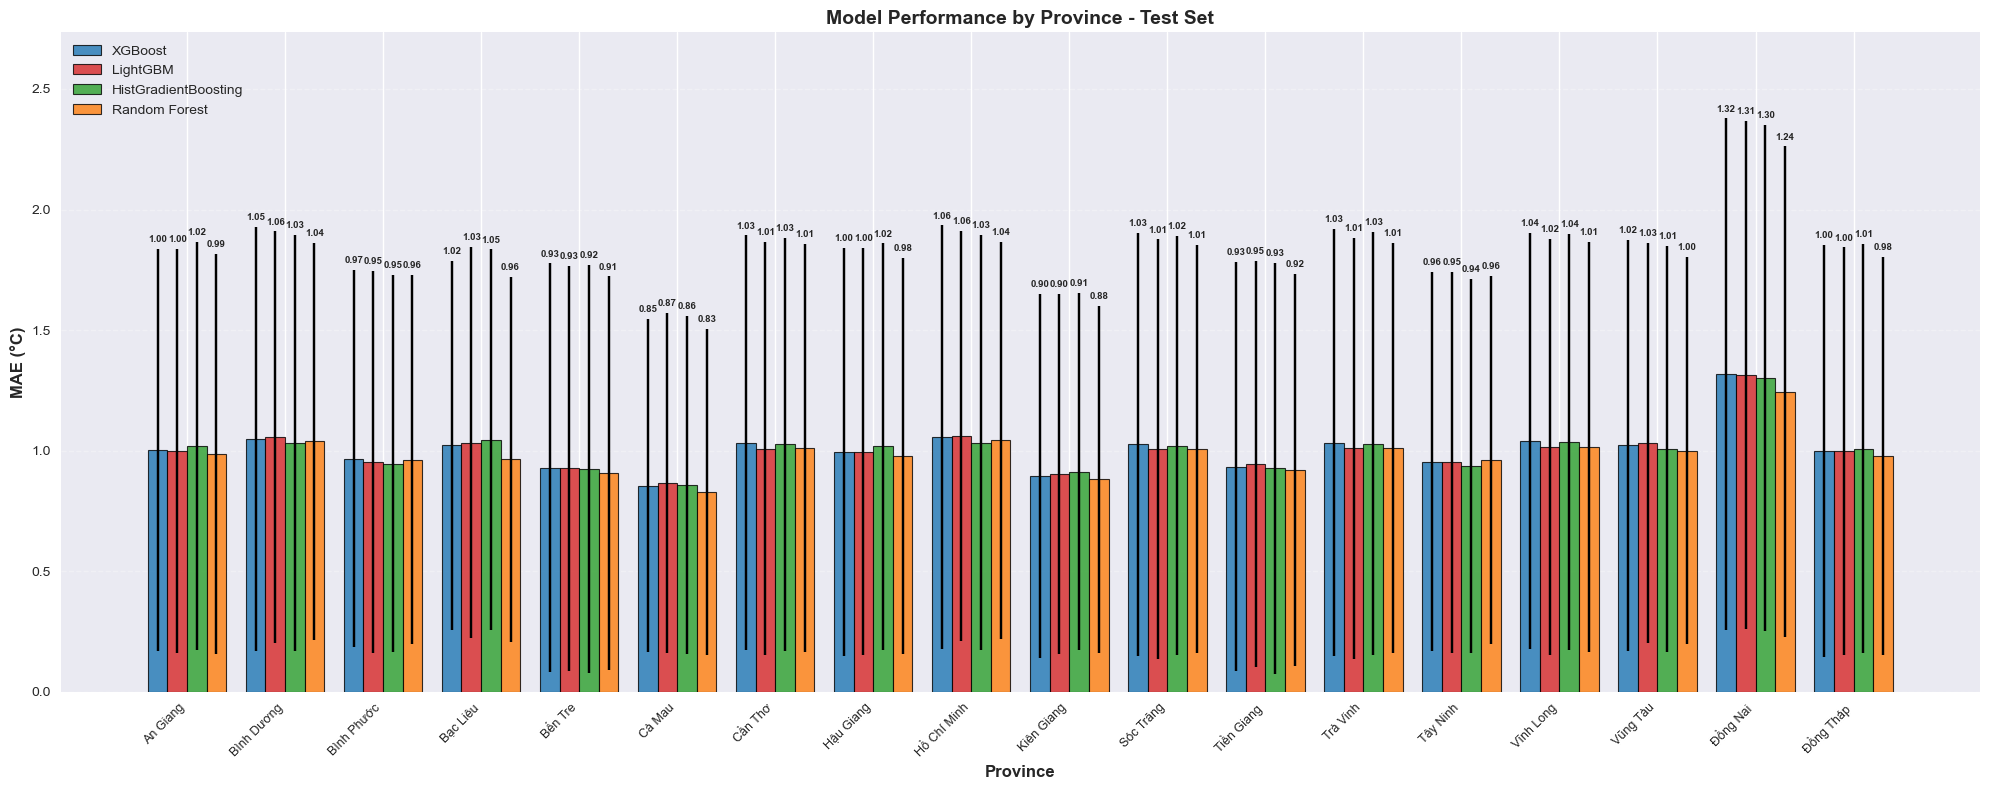

In [21]:
## 6.2. Model Performance Comparison by Province

# Calculate MAE and std for each model by province
print("Calculating model performance by province...")

province_eval_data = {}
all_provinces = sorted(df_test['name'].unique())
models_to_compare = list(loaded_models.keys())

model_display_names_province = {
    'xgb': 'XGBoost',
    'lgb': 'LightGBM',
    'hgb': 'HistGradientBoosting',
    'rf': 'Random Forest'
}

# Calculate metrics for each model by province
for model_key in models_to_compare:
    y_pred = all_predictions[model_key]
    
    # Create DataFrame with predictions and actual values
    eval_df = df_test[['name']].copy()
    eval_df['actual'] = y_test.values
    eval_df['predicted'] = y_pred
    eval_df['abs_error'] = np.abs(eval_df['actual'] - eval_df['predicted'])
    
    # Group by province and calculate MAE and std
    province_stats = eval_df.groupby('name')['abs_error'].agg(['mean', 'std']).reset_index()
    province_stats.columns = ['province', 'mae', 'std']
    
    # Fill NaN std values with 0 (when there's only one sample)
    province_stats['std'] = province_stats['std'].fillna(0)
    
    province_eval_data[model_key] = province_stats
    
    print(f"{model_key.upper()}: Calculated metrics for {len(province_stats)} provinces")

# Create visualization
fig, ax = plt.subplots(1, 1, figsize=(20, 8))

n_provinces = len(all_provinces)
x = np.arange(n_provinces)

# Tổng bề rộng của cả 4 cột trong 1 tỉnh (nhỏ hơn 1 để có khoảng trống giữa các tỉnh)
total_width = 0.8
n_models = len(models_to_compare)
width = total_width / n_models  # bề rộng mỗi cột

colors = {
    'xgb': '#1f77b4',  # Blue
    'rf':  '#ff7f0e',  # Orange
    'hgb': '#2ca02c',  # Green
    'lgb': '#d62728'   # Red
}

# Calculate max y value for ylim
max_mae_plus_std = 0

bars_dict = {}
for idx, model_key in enumerate(models_to_compare):
    if model_key in province_eval_data:
        mae_values = []
        std_values = []
        for province in all_provinces:
            province_data = province_eval_data[model_key][
                province_eval_data[model_key]['province'] == province
            ]
            if len(province_data) > 0:
                mae_val = province_data['mae'].values[0]
                std_val = province_data['std'].values[0]
                mae_values.append(mae_val)
                std_values.append(std_val)
                # Update max for ylim
                max_mae_plus_std = max(max_mae_plus_std, mae_val + std_val)
            else:
                mae_values.append(0)
                std_values.append(0)

        # offset để các cột đối xứng quanh x
        offset = -total_width / 2 + (idx + 0.5) * width
        bars = ax.bar(
            x + offset,
            mae_values,
            width,
            yerr=std_values,
            capsize=3,
            label=model_display_names_province[model_key],
            color=colors[model_key],
            alpha=0.8,
            edgecolor='black',
            linewidth=0.8
        )
        bars_dict[model_key] = bars

        # nhãn giá trị trên mỗi cột
        for i, (bar, mae_val) in enumerate(zip(bars, mae_values)):
            if mae_val > 0:
                height = bar.get_height()
                ax.text(
                    bar.get_x() + bar.get_width() / 2.,
                    height + std_values[i] + 0.02,
                    f'{mae_val:.2f}',
                    ha='center', va='bottom',
                    fontsize=7, fontweight='bold'
                )

# phần còn lại giữ nguyên
ax.set_xlabel('Province', fontsize=12, fontweight='bold')
ax.set_ylabel('MAE (°C)', fontsize=12, fontweight='bold')
ax.set_title('Model Performance by Province - Test Set', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(all_provinces, rotation=45, ha='right', fontsize=9)
ax.set_ylim(0, max_mae_plus_std * 1.15 if max_mae_plus_std > 0 else 1.5)
ax.grid(True, alpha=0.3, axis='y', linestyle='--')
ax.set_axisbelow(True)
ax.legend(loc='upper left', fontsize=10)

plt.tight_layout()
plt.savefig('../figures/model_performance_by_province.png', dpi=300, bbox_inches='tight')
print("✓ Saved: figures/model_performance_by_province.png")
plt.show()